In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import shap
import warnings
warnings.filterwarnings("ignore")

In [2]:
file_path = "/content/drive/MyDrive/Project Datasets/marketing_campaign.csv"
df = pd.read_csv(file_path, sep='\t')

In [4]:
df = df.dropna(subset=['Income'])
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
df['Customer_Tenure'] = (pd.to_datetime('2015-01-01') - df['Dt_Customer']).dt.days

# Age and Total Spend
df['Age'] = 2015 - df['Year_Birth']
df['TotalSpend'] = df[['MntWines', 'MntFruits', 'MntMeatProducts',
                       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum(axis=1)
df['TotalPurchases'] = df[['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].sum(axis=1)

In [5]:
# Customer Segmentation using KMeans

seg_data = df[['Income', 'Age', 'Customer_Tenure', 'TotalSpend', 'TotalPurchases']].copy()
scaler = StandardScaler()
seg_scaled = scaler.fit_transform(seg_data)

kmeans = KMeans(n_clusters=4, random_state=42)
df['Segment'] = kmeans.fit_predict(seg_scaled)

print("\n✅ Customer Segmentation Completed. Segment counts:")
print(df['Segment'].value_counts())


✅ Customer Segmentation Completed. Segment counts:
Segment
0    645
3    544
1    542
2    485
Name: count, dtype: int64


In [6]:
# Simulate Churn Label (based on Recency proxy)

df['Churn'] = df['Recency'].apply(lambda x: 1 if x > 90 else 0)

In [7]:
# Churn Prediction using Random Forest

features = ['Income', 'Age', 'Customer_Tenure', 'TotalSpend', 'TotalPurchases', 'NumWebVisitsMonth', 'Complain']
X = df[features]
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("\n🔍 Churn Prediction Report:")
print(classification_report(y_test, y_pred))


🔍 Churn Prediction Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       403
           1       0.75      0.07      0.13        41

    accuracy                           0.91       444
   macro avg       0.83      0.54      0.54       444
weighted avg       0.90      0.91      0.88       444



In [8]:
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Confusion Matrix:
[[402   1]
 [ 38   3]]


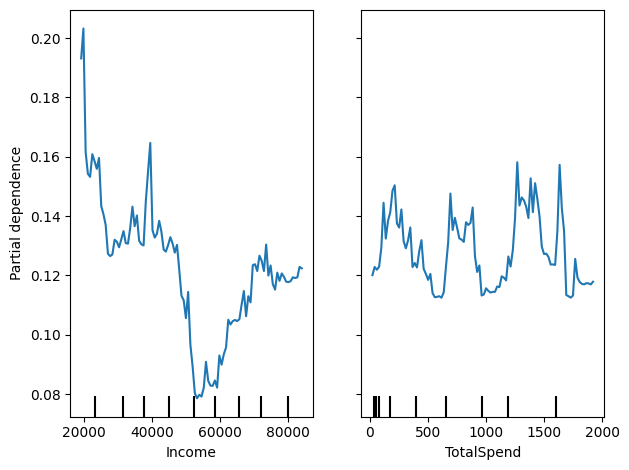

In [12]:
# Explain Model Predictions

from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(clf, X_test, ['Income', 'TotalSpend'], kind='average')
plt.tight_layout()
plt.show()


In [15]:
# Export to CSV for Power BI

df.to_csv("customer_churn_segments.csv", index=False)